In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('laggedData_cap2.csv',encoding='latin-1',
                   index_col='Index',parse_dates=True)
data = data.drop(labels=['Name'],axis=1)


Y = data[data['dayLag30'].isnull()==False]['Demand(MW)']
X = data[data['dayLag30'].isnull()==False].iloc[:,1:]
X.head()

,Forecast(MW),Temp,holiday,DofWk,daylight,dayLag1,dayLag2,dayLag3,dayLag4,dayLag5,...,dayLag21,dayLag22,dayLag23,dayLag24,dayLag25,dayLag26,dayLag27,dayLag28,dayLag29,dayLag30
Index,,,,,,,,,,,,,,,,,,,,,
2015-07-31 00:00:00,5280.0,70.0,0,5,0,5135.0,5093.0,4775.0,4282.0,4703.0,...,3756.0,3720.0,4173.0,4143.0,3544.0,3748.0,4488.0,5012.0,4709.0,5250.0
2015-07-31 01:00:00,5211.0,70.0,0,5,0,5072.0,5023.0,4720.0,4251.0,4655.0,...,3675.0,3697.0,4085.0,4063.0,3547.0,3709.0,4452.0,4898.0,4532.0,4847.0
2015-07-31 02:00:00,4964.0,69.1,0,5,0,4792.0,4782.0,4469.0,4120.0,4524.0,...,3522.0,3554.0,3868.0,3848.0,3476.0,3550.0,4262.0,4634.0,4332.0,4593.0
2015-07-31 03:00:00,4622.0,68.0,0,5,0,4485.0,4511.0,4227.0,3932.0,4321.0,...,3420.0,3450.0,3693.0,3657.0,3366.0,3363.0,4004.0,4354.0,4159.0,4473.0
2015-07-31 04:00:00,4392.0,69.1,0,5,0,4416.0,4415.0,4189.0,3899.0,4252.0,...,3491.0,3541.0,3708.0,3652.0,3414.0,3325.0,3906.0,4255.0,4149.0,4512.0


In [16]:
#spliting data between training and test set--------------------
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size = 0.15,random_state=42)

benchmark_x = X_test[X_test['Forecast(MW)'].isnull()==False].pop('Forecast(MW)')
benchmark_y = pd.concat([Y_test,benchmark_x],join='inner',axis=1).iloc[:,0]

X_train = X_train.drop(labels=['Forecast(MW)'],axis=1)
X_test = X_test.drop(labels=['Forecast(MW)'],axis=1)

In [17]:
import warnings 
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():#suppress 1D array warning from sklearn
    warnings.simplefilter("ignore")
    fxn()

#feature standarization/normalization-----------
    from sklearn.preprocessing import StandardScaler
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    catavars = []
    for i in [X_test,X_train]:
        catas = i[['holiday', 'DofWk', 'daylight']]
        catavars.append(catas)
        i.drop(labels=['holiday', 'DofWk', 'daylight'],axis=1,inplace=True)

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    Y_train = scaler_Y.fit_transform(Y_train)
    Y_test = scaler_Y.transform(Y_test)

    benchmark_x = scaler_X.fit_transform(benchmark_x)
    benchmark_y = scaler_Y.transform(benchmark_y)

    X_test = np.append(X_test,catavars[0].values,axis=1)
    X_train = np.append(X_train,catavars[1].values,axis=1)

In [20]:
#Benchmark Scores----------------------------
from sklearn.metrics import mean_squared_error,r2_score

Bench_error = mean_squared_error(benchmark_y,benchmark_x)
Bench_r2 = r2_score(benchmark_y,benchmark_x)
print('Benchmark Mean Squared Error =',Bench_error)
print('Benchmark R^2 =',Bench_r2)

Benchmark Mean Squared Error = 0.0807626684569
Benchmark R^2 = 0.917205637978


In [21]:
#Linear Rgression -------------------------
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False)
linear.fit(X_train,Y_train)
ypred2 = linear.predict(X_test)
R_sq = r2_score(ypred2,Y_test)
MSE_lin = mean_squared_error(ypred2,Y_test)
print('Linear Regression Mean Squared Error =',MSE_lin)
print('Linear Regression R^2 =',R_sq)

Linear Regression Mean Squared Error = 0.0821502600287
Linear Regression R^2 = 0.907173908159


In [24]:
#SVM Regressor ----------------------------------------------------------
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

supportvec = LinearSVR()
parametervec = {'C':[.14,.01,.3],'epsilon':[.01,.20,.5]}
grid2 = GridSearchCV(estimator=supportvec,param_grid=parametervec,cv=5)
grid2.fit(X_train,Y_train)
best_para_vec = grid2.best_params_
best_acc_vec = grid2.best_score_
print('Best parameters -',best_para_vec,'With highest accuracy of-',best_acc_vec)

supportvec2 = LinearSVR(C=.14, epsilon=.2 ,max_iter=10000)
supportvec2.fit(X_train,Y_train)
ypred1 = supportvec2.predict(X_test)
R_sq_vec = r2_score(ypred1,Y_test)
MSE_vec = mean_squared_error(ypred1,Y_test)
print('Support Vector Machine Mean Squared Error =',MSE_vec)
print('Support Vector Machine R^2 =',R_sq_vec)

Best parameters - {'C': 0.14, 'epsilon': 0.2} With highest accuracy of- 0.915793737617
Support Vector Machine Mean Squared Error = 0.0795477346922
Support Vector Machine R^2 = 0.909426856522


In [31]:
#KNN Rgressor ----------------------------------------------------------
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
parameterknn = {'n_neighbors':[5,2,3],'weights':['uniform','distance']}
grid1 = GridSearchCV(estimator=knn,param_grid=parameterknn,cv=5)
grid1.fit(X_train,Y_train)
best_para_knn = grid1.best_params_
best_acc_knn = grid1.best_score_
print('Best parameters -',best_para_knn,'With highest accuracy of-',best_acc_knn)

knn2 = KNeighborsRegressor(n_neighbors= 3,weights= 'distance')
knn2.fit(X_train,Y_train)
ypred = knn2.predict(X_test)
R_sq_knn = r2_score(ypred,Y_test)
MSE_knn = mean_squared_error(ypred,Y_test)
print('K-Neartest Neighbors Mean Squared Error =',MSE_knn)
print('K-Neartest Neighbors R^2 =',R_sq_knn)

Best parameters - {'n_neighbors': 3, 'weights': 'distance'} With highest accuracy of- 0.970637300033
K-Neartest Neighbors Mean Squared Error = 0.0229797734974
K-Neartest Neighbors R^2 = 0.975667790254


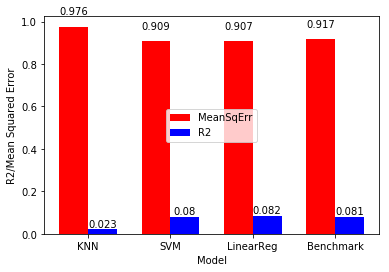

In [32]:
#Visualize results------------------------------------
error = [MSE_knn,MSE_vec,MSE_lin,Bench_error]
r2 = [R_sq_knn,R_sq_vec,R_sq,Bench_r2]
results = pd.DataFrame([error,r2],index=['MeanSqErr','R2'],
                       columns=['KNN','SVM','LinearReg','Benchmark']).transpose()
width = 0.35   
ind = np.arange(4)
fig, ax = plt.subplots()
rects1 = ax.bar(range(4),results['R2'], width, color='r',
                tick_label=['KNN','SVM','LinearReg','Benchmark'])
rects2 = ax.bar(ind + width,results['MeanSqErr'], width, color='blue')
ax.set_xticks(ind + width / 2)
plt.ylabel('R2/Mean Squared Error')
plt.xlabel('Model')
ax.legend((rects1[0], rects2[0]),['MeanSqErr','R2'],loc=10)

#Attach a text label above each bar displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                str(round(height, 3)),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()